<a href="https://colab.research.google.com/github/Lubricy/notebooks/blob/master/volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.version.VERSION)
print(tf.test.gpu_device_name())

TensorFlow 2.x selected.
2.1.0
/device:GPU:0


In [0]:
import seaborn as sns 

In [0]:
import matplotlib as mpl
from datetime import timedelta
mpl.rcParams['figure.figsize'] = [16.0, 12.0]
mpl.rcParams['lines.linewidth'] = 1.0

In [4]:
import urllib
coin = 'BTC'
with urllib.request.urlopen(f"http://www.cryptodatadownload.com/cdd/Coinbase_{coin}USD_1h.csv") as f:
    print(next(f))
    data = pd.read_csv(f)
data['Date']= pd.to_datetime(data['Date'], format='%Y-%m-%d %I-%p')

b'Timestamps are UTC timezone,https://www.CryptoDataDownload.com\r\n'


In [0]:
data.index=data['Date']

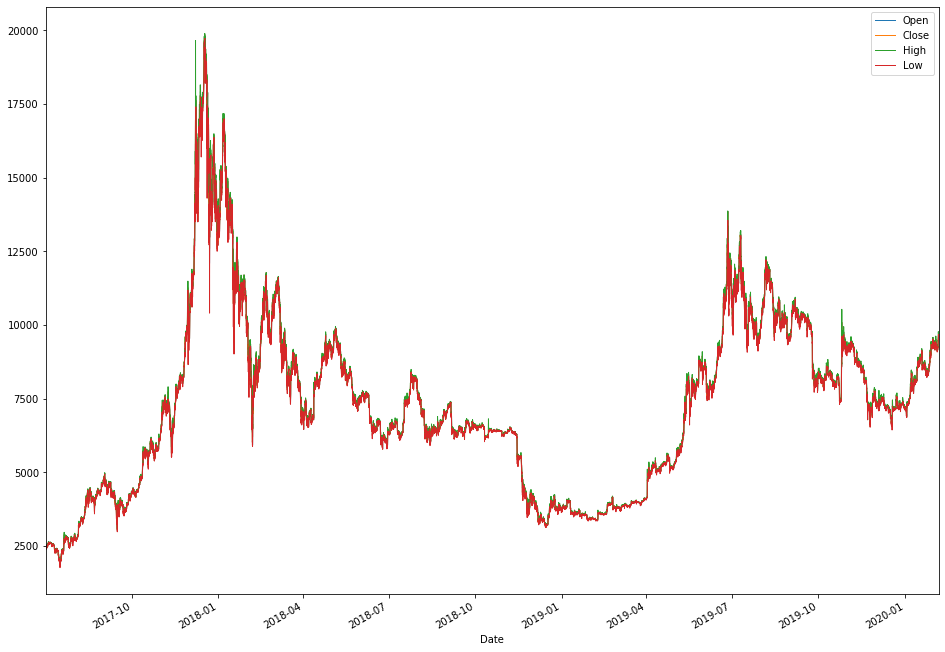

In [6]:
data[['Open', 'Close', 'High', 'Low']].plot()


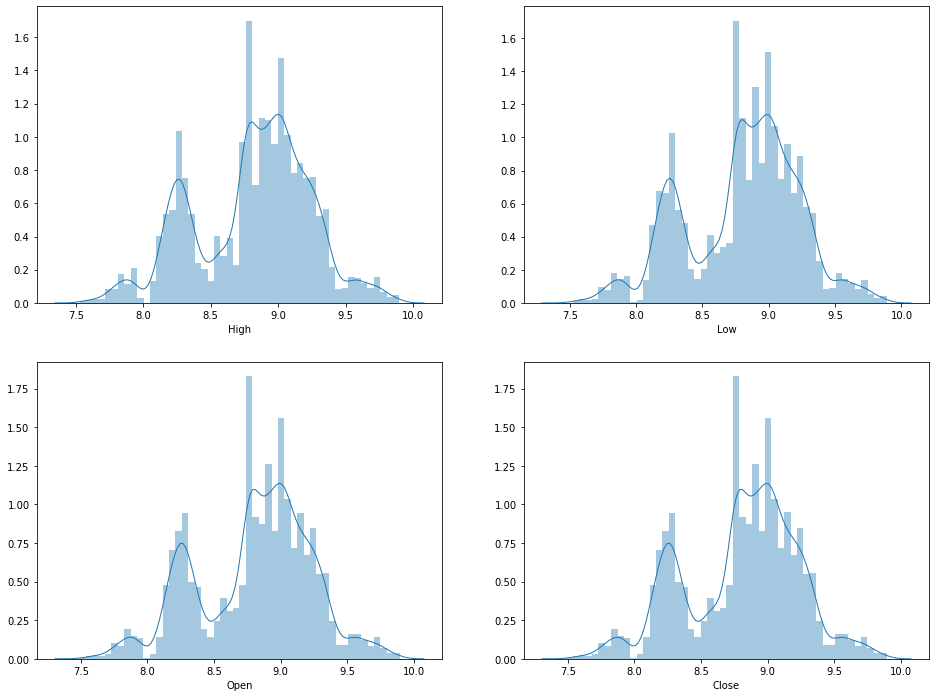

In [7]:
for i, d in enumerate(['High', 'Low', 'Open', 'Close'],1):
  plt.subplot(2,2,i)
  sns.distplot(np.log(data[d]))


In [0]:
def slice(start=None, end=None):
  start = pd.to_datetime(start)
  end = pd.to_datetime(end)
  def _slice(df):
    return df[(df.index >= start) & (df.index < end)].copy()
  return _slice

start_date = '2019-01-01' #@param {type:"date"}
end_date = '2019-07-01' #@param {type:"date"}

In [0]:
modes = ['Open-Open', 'Close-Close', 'High-Low', 'Low-High']

In [0]:
def calculate_return_volatility(data, pv_fv=modes, windows = [24, 7 * 24, 30 * 24, 60 * 24, 180 * 24]):
  for mode in pv_fv:
    pv, fv = mode.split('-')
    log_pv = np.log(data[pv].to_numpy())
    log_fv = np.log(data[fv].to_numpy())
    for window in windows:
      log_return = (log_fv[:-window] - log_pv[window:])
      data.loc[:, f'LogReturn_{mode}_{window}'] = np.append(log_return, [0]*window)
      volatility = np.std(np.vstack([data[f'LogReturn_{mode}_{window}'].to_numpy()[i:i-window] for i in range(window)]), axis=0)
      data.loc[:, f'volatility_{mode}_{window}'] = np.append(volatility, [0]*window)

In [0]:
def plot_data(name, data, pv_fv=modes, windows = [24, 7 * 24, 30 * 24, 60 * 24, 180 * 24], bars=[1]):
  plots = len(pv_fv)
  linestyles = ['-','--', ':']
  for index, mode in enumerate(pv_fv, start=1):
    plt.subplot(plots, 1, index)
    for wid, window in enumerate(windows):
      data[f'{name}_{mode}_{window}'].plot()
      for bar in bars:
        plt.axvline(x=data.index[-1] + timedelta(hours=window * bar), ls=linestyles[bar], color=f'C{wid}')
    plt.axhline(color='k')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

In [0]:
calculate_return_volatility(data)

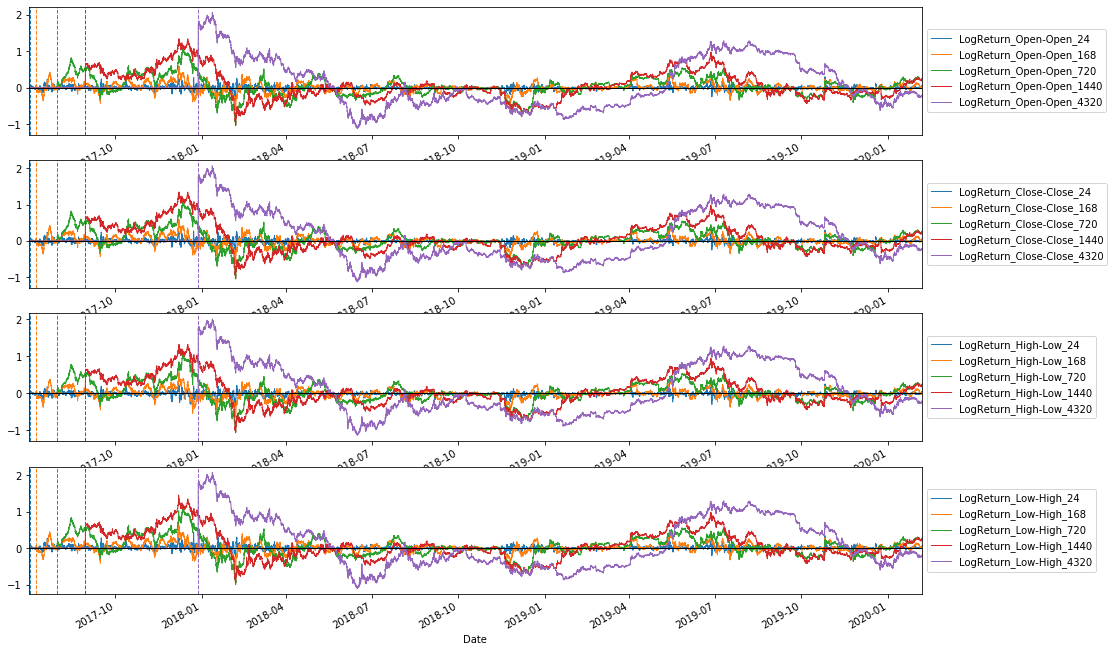

In [13]:
plot_data('LogReturn', data)

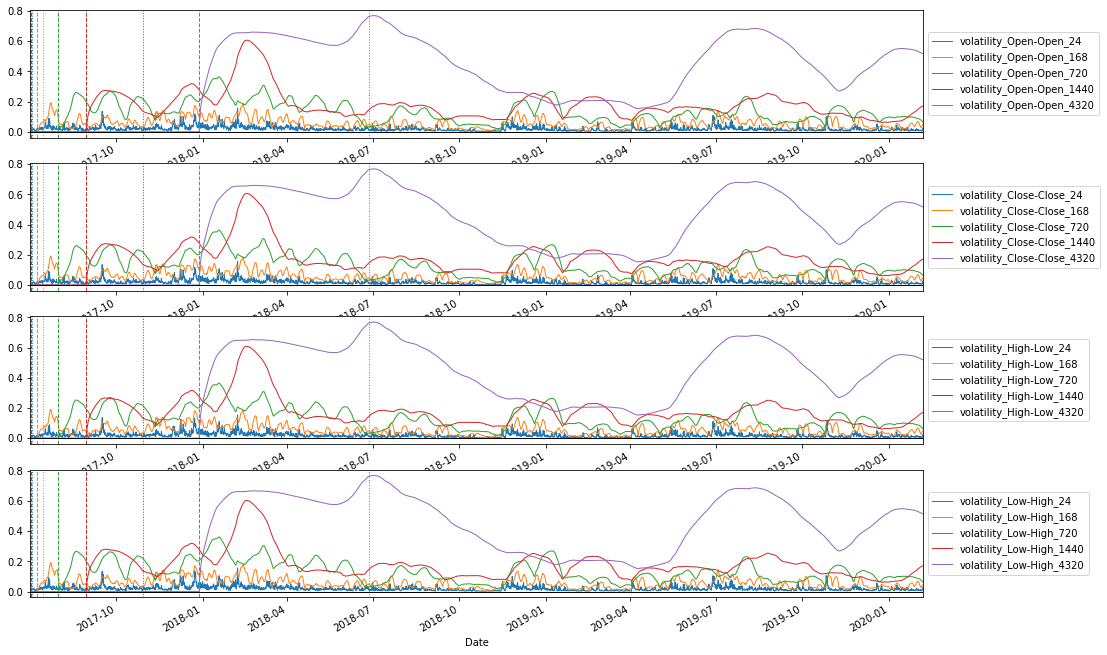

In [14]:
plot_data('volatility', data, bars=[1,2])

In [0]:
def plot_diff(name, data, pv_fv=modes, windows = [24, 7 * 24, 30 * 24, 60 * 24, 180 * 24], bars=[1]):
  plots = len(windows)
  for index, window in enumerate(windows, start=1):
    plt.subplot(plots, 1, index)
    for mode in pv_fv:
      data[f'{name}_{mode}_{window}'].plot()
    for bar in bars:
      plt.axvline(x=data.index[-1] + timedelta(hours=window * bar), ls='--')
    plt.axhline(color='k')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

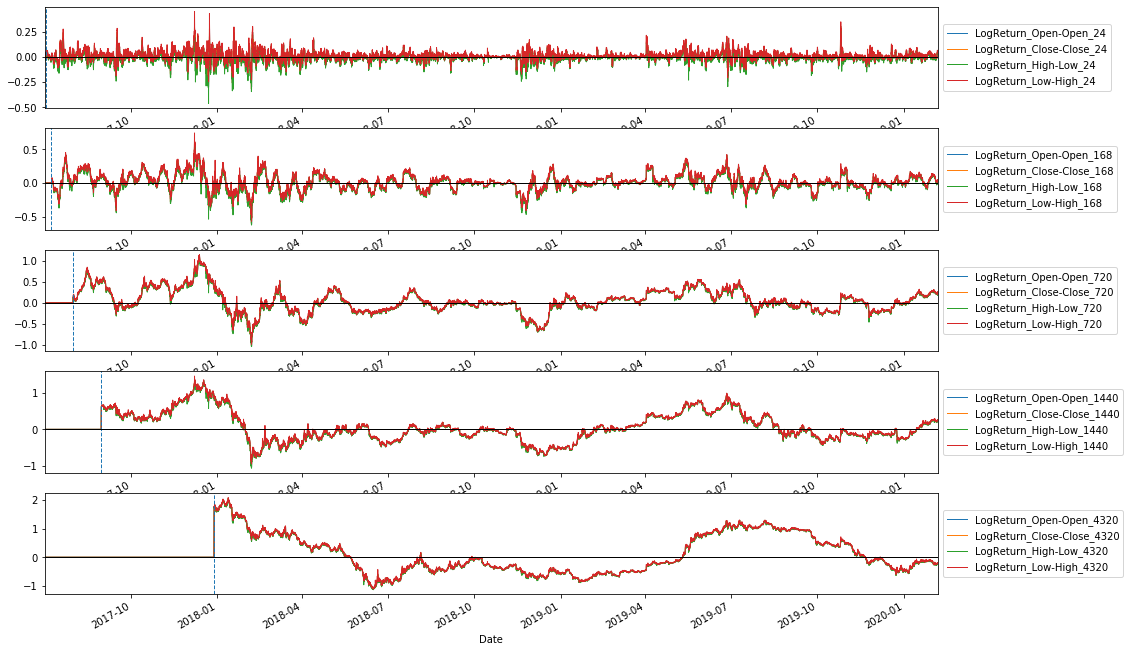

In [16]:
plot_diff('LogReturn', data)

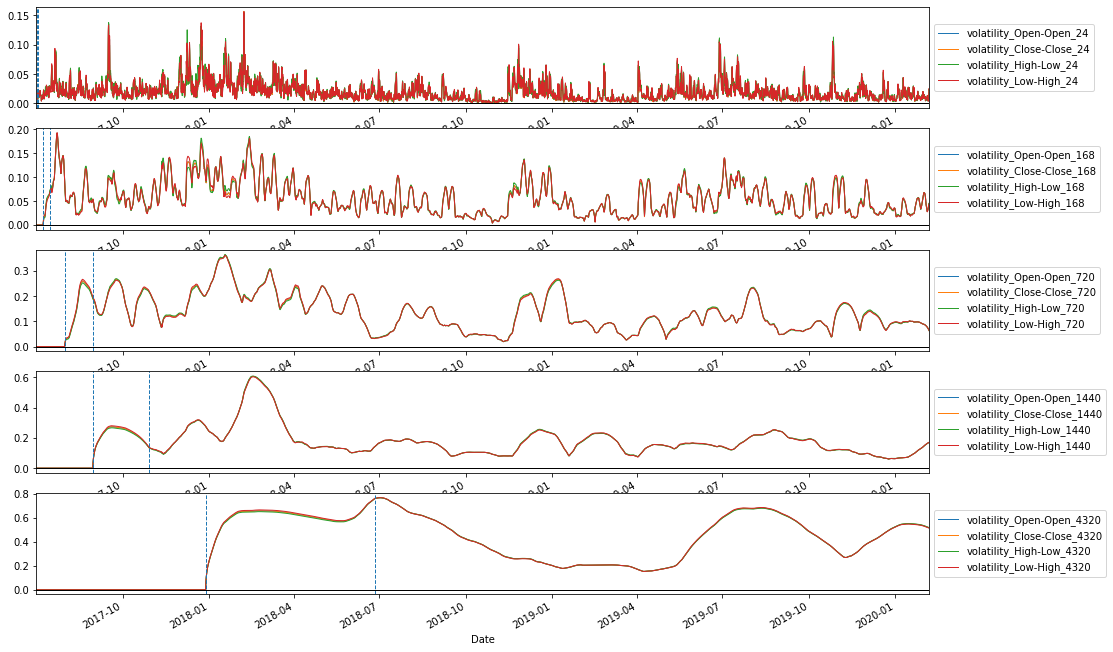

In [17]:
plot_diff('volatility', data, bars=[1,2])

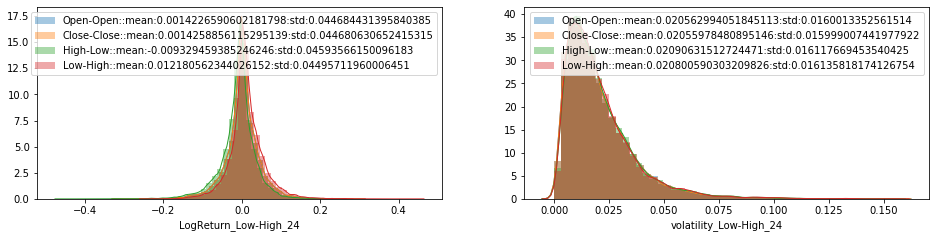

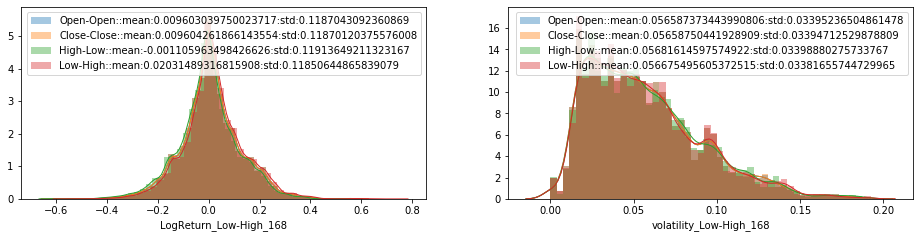

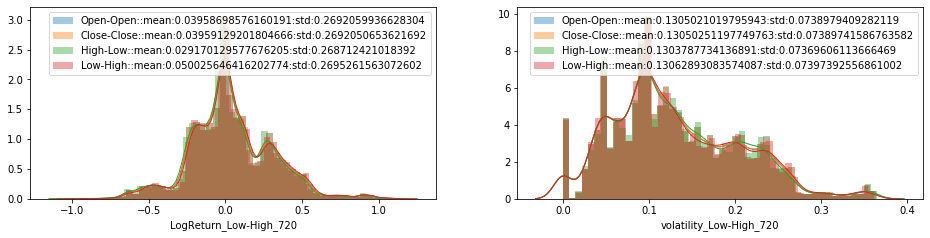

In [18]:
windows = [24, 24 * 7, 24 * 30]
for widx, window in enumerate(windows):
  for idx, plot in enumerate(['LogReturn', 'volatility']):
    plt.subplot(len(windows), 2, widx * 2 + idx + 1)
    for mode in modes:
      sns.distplot(data[f'{plot}_{mode}_{window}'], 
                  label='{mode}::mean:{mean}:std:{std}'.format(
                      mode=mode, 
                      mean=data[f'{plot}_{mode}_{window}'].mean(), 
                      std=data[f'{plot}_{mode}_{window}'].std()))
    plt.legend()
  plt.show()

In [0]:
calculate_return_volatility(data, windows=[6, 12, 48])